# Importing the Libraries

In [112]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
import pickle
import optuna


sns.set_palette('crest')

# Defining functions

In [113]:
from tkinter import font


def print_classification_report(y_test, x_test, model, title):
    print(f'Classification Report - {title}\n')
    test = str(classification_report(y_test, model.predict(x_test)))
    test.split('\n')
    for line in test.split('\n'):
        print(line)

def plot_heatmap(x_test, y_test, model, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(
        y_test, 
        model.predict(x_test), 
        normalize='true'), 
        annot=True, 
        fmt='.4f', 
        xticklabels=['No TPK', 'TPK'], 
        yticklabels=['No TPK', 'TPK'], 
        annot_kws={
            'fontsize': 16, 
            'fontweight': 'bold'},
        )
    plt.xlabel('Predicted', fontsize=18)
    plt.ylabel('Actual', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(f'Confusion Matrix - {title}', fontsize=22)


def plot_roc_curve(X_test, Y_test, X_train, Y_train, model, title):
    curva_test = roc_curve(Y_test, model.predict_proba(X_test)[:,1])
    curva_train = roc_curve(Y_train, model.predict_proba(X_train)[:,1])
    fig = plt.figure(figsize=(10, 7))
    sns.lineplot(x=curva_test[0], y=curva_test[1], label='Test ROC Curve', color='orange')
    sns.lineplot(x=curva_train[0], y=curva_train[1], label='Train ROC Curve', color='blue', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title(f'ROC Curve - {title}',fontsize=22)
    plt.legend(fontsize=14)
    
def scale_pos_weight_balancing(params, inicial_value, final_value, step, X_train, Y_train, X_test, Y_test):
    pesos = np.round(np.arange(inicial_value, final_value, step), 5)
    best = 0

    for i in pesos:
        params['scale_pos_weight'] = i

        xgb_optuna = XGBClassifier()
        xgb_optuna.set_params(**params)

        xgb_optuna.fit(X_train, Y_train)
        Y_pred = xgb_optuna.predict(X_test)

        tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred, normalize='true').ravel()
        if abs(tn - tp) <= 0.01:

            print(i)
            print_classification_report(Y_test, X_test, xgb_optuna, f'XGBoost - Scale Pos Weight = {i}')
            print()
            best = i
            
    print("Best scale_pos_weight (that balances the model towards the minority class): " + str(best))
    return best

def predict(model,test, y,normalizer):
    input_test = randint(0, len(test))
    row_input = pd.DataFrame(test.iloc[input_test]).T
    try:
        print_input = pd.DataFrame(normalizer.inverse_transform(row_input), columns=row_input.columns)
    except:
        print('ruim')
        print_input = row_input 
    print('Input: ')
    display(row_input)
    print(f'The combat was between 4 players level {print_input.players_level.values[0]} against {print_input.num_of_monsters.values[0]} monster(s) CR {print_input.monster_cr.values[0]}')
    print('Expected: ', y.iloc[input_test])
    print(type(row_input.values))
    print('Predicted: ', bool(model.predict(row_input.values)[0]))

# Importing the Dataset

In [3]:
df = pd.read_csv('../Data/results_v6.csv')
df.sample(5)


,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_ac,p4_avg_save,num_of_monsters,monster_name,monster_cr,monster_ac,monster_hp,monster_type,dificulty,players_level
13305,Ranger,23,14,3,Druid,24,13,3,Rogue,24,...,16,3,1,Giant Ape,7.000,12,157,beast,0.000000,3
72161,Monk,12,11,2,Bard,11,16,2,Barbarian,16,...,14,2,1,Kruthik Hive Lord,5.000,20,102,monstrosity,0.000000,2
16701,Bard,45,14,3,Bard,38,13,3,Fighter,38,...,11,3,10,Xvart,0.125,13,7,monstrosity,0.843584,5
38216,Barbarian,35,15,3,Wizzard,18,14,3,Sorcerer,18,...,16,3,2,Chimera,6.000,14,114,monstrosity,0.000000,4
88458,Rogue,29,12,3,Barbarian,41,12,3,Ranger,38,...,15,3,10,Cockatrice,0.500,11,27,monstrosity,0.907278,4


In [4]:
df_test = pd.read_csv('../Data/test_sample.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4488 entries, 0 to 4487
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p1_class         4488 non-null   object 
 1   p1_hp            4488 non-null   int64  
 2   p1_ac            4488 non-null   int64  
 3   p1_avg_save      4488 non-null   int64  
 4   p2_class         4488 non-null   object 
 5   p2_hp            4488 non-null   int64  
 6   p2_ac            4488 non-null   int64  
 7   p2_avg_save      4488 non-null   int64  
 8   p3_class         4488 non-null   object 
 9   p3_hp            4488 non-null   int64  
 10  p3_ac            4488 non-null   int64  
 11  p3_avg_save      4488 non-null   int64  
 12  p4_class         4488 non-null   object 
 13  p4_hp            4488 non-null   int64  
 14  p4_ac            4488 non-null   int64  
 15  p4_avg_save      4488 non-null   int64  
 16  num_of_monsters  4488 non-null   int64  
 17  monster_name  

In [5]:
df_test_result = df_test['dificulty']==0
df_test_result.head()


0    False
1    False
2    False
3    False
4     True
Name: dificulty, dtype: bool

# Cleaning the Data

## Dropping miswrote data

In [6]:
df = df[df['p1_class'] != '22']
df = df[df['dificulty'] >= 0]
df = df[df['monster_cr'] != -1]
df = df[df['players_level'] <= 5]
print(df.shape)
df.head()

(102817, 24)


,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_ac,p4_avg_save,num_of_monsters,monster_name,monster_cr,monster_ac,monster_hp,monster_type,dificulty,players_level
0,Artificer,38,12,3,Bard,38,13,3,Barbarian,51,...,14,3,1,Efreeti,11.00,17,200,elemental,0.869491,5
1,Bard,24,12,3,Barbarian,36,17,3,Sorcerer,13,...,15,3,10,Giant Bat,0.25,13,22,beast,0.067640,3
2,Ranger,17,12,2,Ranger,12,15,2,Druid,12,...,14,2,1,Galeb Duhr,6.00,16,85,elemental,1.000000,2
3,Fighter,32,18,3,Paladin,32,19,3,Paladin,21,...,13,3,1,Blue Slaad,7.00,15,123,aberration,0.285597,3
4,Cleric,26,12,3,Paladin,34,15,3,Cleric,25,...,13,3,4,Lizardfolk Shaman,2.00,13,27,humanoid,0.445773,4


## Dropping unuseful columns

In [7]:
df['TPK'] = df['dificulty'] == 0
df.drop(columns=['dificulty','monster_name'], axis=1, inplace=True)
print(df.shape)
df.head()

(102817, 23)


,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_hp,p4_ac,p4_avg_save,num_of_monsters,monster_cr,monster_ac,monster_hp,monster_type,players_level,TPK
0,Artificer,38,12,3,Bard,38,13,3,Barbarian,51,...,43,14,3,1,11.00,17,200,elemental,5,False
1,Bard,24,12,3,Barbarian,36,17,3,Sorcerer,13,...,25,15,3,10,0.25,13,22,beast,3,False
2,Ranger,17,12,2,Ranger,12,15,2,Druid,12,...,14,14,2,1,6.00,16,85,elemental,2,False
3,Fighter,32,18,3,Paladin,32,19,3,Paladin,21,...,27,13,3,1,7.00,15,123,aberration,3,False
4,Cleric,26,12,3,Paladin,34,15,3,Cleric,25,...,25,13,3,4,2.00,13,27,humanoid,4,False


In [8]:
df_test.drop(columns=['monster_name','dificulty'], inplace=True)
print(df_test.shape)
df_test.head()

(4488, 22)


,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_class,p4_hp,p4_ac,p4_avg_save,num_of_monsters,monster_cr,monster_ac,monster_hp,monster_type,players_level
0,Fighter,10,18,2,Artificer,9,17,2,Cleric,6,...,Cleric,8,18,2,1,1.00,13,28,beast,1
1,Paladin,40,18,3,Rogue,25,16,3,Fighter,37,...,Ranger,57,17,3,1,5.00,15,75,monstrosity,5
2,Warlock,15,13,2,Ranger,17,16,2,Fighter,17,...,Cleric,12,14,2,2,2.00,13,30,beast,2
3,Monk,16,13,3,Monk,18,11,3,Paladin,26,...,Artificer,30,12,3,1,5.00,13,95,beast,3
4,Wizzard,4,11,2,Paladin,11,15,2,Sorcerer,6,...,Bard,6,16,2,10,0.25,15,11,construct,1


# Exploring the Data

## Plotting the data

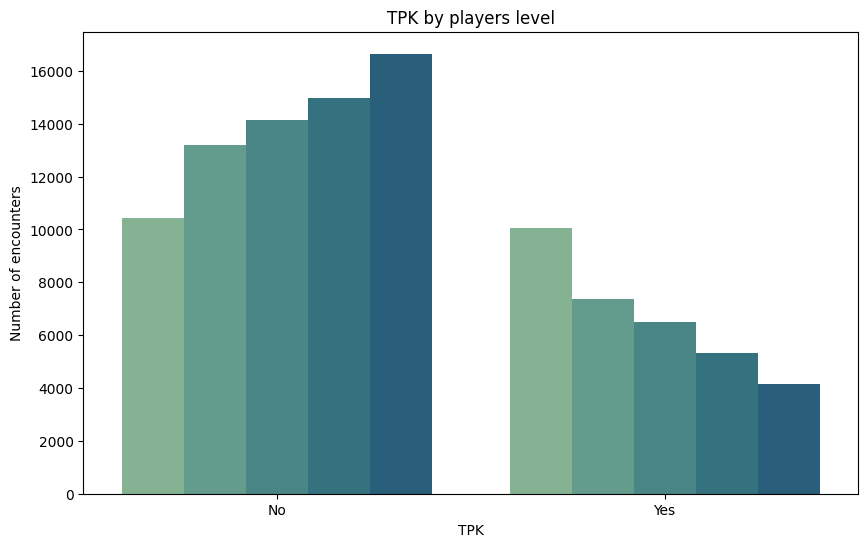

In [9]:
fig = plt.figure(figsize=(10,6))
ax = sns.countplot(x='TPK', data=df, hue='players_level')
ax.set_title('TPK by players level')
ax.set_xlabel('TPK')
ax.set_ylabel('Number of encounters')
ax.set_xticklabels(['No','Yes'])
ax.legend([],[], frameon=False)

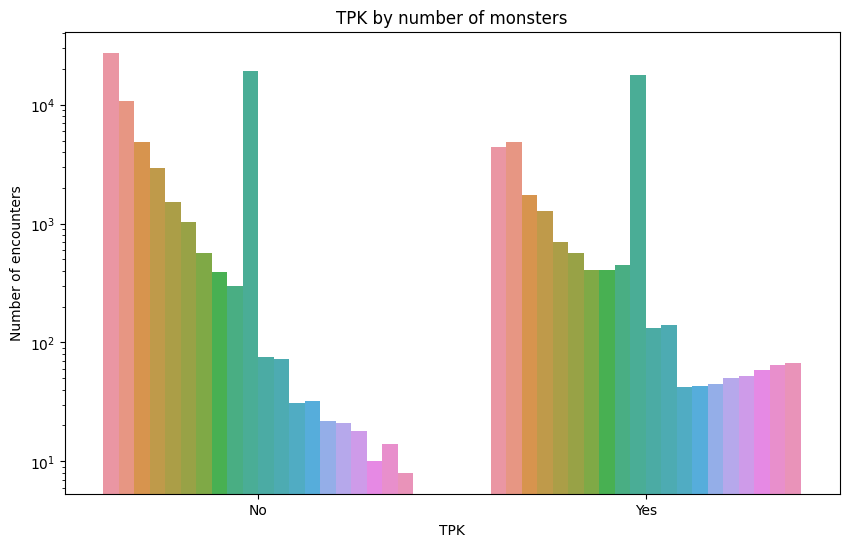

In [10]:
fig = plt.figure(figsize=(10,6))
ax = sns.countplot(x='TPK', data=df, hue='num_of_monsters')
ax.set_title('TPK by number of monsters')
ax.set_xlabel('TPK')
ax.set_ylabel('Number of encounters')
ax.set_xticklabels(['No','Yes'])
ax.set_yscale('log')
ax.legend([],[], frameon=False);

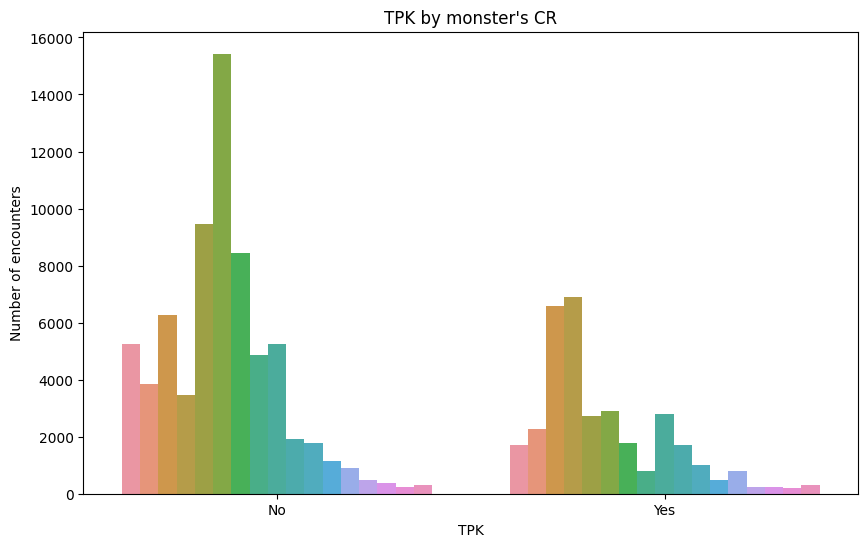

In [11]:
fig = plt.figure(figsize=(10,6))
ax = sns.countplot(x='TPK', data=df, hue='monster_cr')
ax.set_title("TPK by monster's CR")
ax.set_xlabel('TPK')
ax.set_ylabel('Number of encounters')
ax.set_xticklabels(['No','Yes'])
ax.legend([],[], frameon=False);

## Seeing the correlation between the data

### Correlation in regards to the target

In [12]:
corr_matrix = df.corr(numeric_only=True)
abs(corr_matrix['TPK']).sort_values(ascending = False)

TPK                1.000000
num_of_monsters    0.302892
players_level      0.204874
p3_hp              0.203828
p1_hp              0.202123
p2_hp              0.201363
p4_hp              0.200979
p2_avg_save        0.173201
p3_avg_save        0.173201
p4_avg_save        0.173201
p1_avg_save        0.173201
p3_ac              0.041813
p4_ac              0.040716
p1_ac              0.040125
p2_ac              0.036435
monster_cr         0.036085
monster_hp         0.009135
monster_ac         0.003594
Name: TPK, dtype: float64

### Matrix of correlation

In [13]:
corr_matrix

,p1_hp,p1_ac,p1_avg_save,p2_hp,p2_ac,p2_avg_save,p3_hp,p3_ac,p3_avg_save,p4_hp,p4_ac,p4_avg_save,num_of_monsters,monster_cr,monster_ac,monster_hp,players_level,TPK
p1_hp,1.000000,0.097779,0.760145,0.771475,-0.000335,0.760145,0.771640,-0.002646,0.760145,0.771471,0.001654,0.760145,0.011625,0.307554,0.135904,0.277164,0.877996,-0.202123
p1_ac,0.097779,1.000000,0.003035,0.003665,0.003515,0.003035,0.006203,0.002559,0.003035,0.005389,-0.002774,0.003035,-0.003024,0.003276,0.002211,0.001906,0.005144,-0.040125
p1_avg_save,0.760145,0.003035,1.000000,0.760556,0.002004,1.000000,0.760603,0.002767,1.000000,0.760499,0.002318,1.000000,0.015902,0.274914,0.123667,0.248262,0.865503,-0.173201
p2_hp,0.771475,0.003665,0.760556,1.000000,0.096176,0.760556,0.770257,-0.002652,0.760556,0.772318,0.002066,0.760556,0.010628,0.308320,0.135374,0.276738,0.878134,-0.201363
p2_ac,-0.000335,0.003515,0.002004,0.096176,1.000000,0.002004,-0.001092,0.000018,0.002004,-0.000010,-0.003318,0.002004,0.004797,-0.004691,-0.007957,-0.002871,-0.000855,-0.036435
p2_avg_save,0.760145,0.003035,1.000000,0.760556,0.002004,1.000000,0.760603,0.002767,1.000000,0.760499,0.002318,1.000000,0.015902,0.274914,0.123667,0.248262,0.865503,-0.173201
p3_hp,0.771640,0.006203,0.760603,0.770257,-0.001092,0.760603,1.000000,0.091890,0.760603,0.771941,0.002221,0.760603,0.010298,0.308398,0.135855,0.276856,0.877997,-0.203828
p3_ac,-0.002646,0.002559,0.002767,-0.002652,0.000018,0.002767,0.091890,1.000000,0.002767,-0.001706,-0.003256,0.002767,-0.004786,0.002592,0.000725,0.001429,-0.002621,-0.041813
p3_avg_save,0.760145,0.003035,1.000000,0.760556,0.002004,1.000000,0.760603,0.002767,1.000000,0.760499,0.002318,1.000000,0.015902,0.274914,0.123667,0.248262,0.865503,-0.173201
p4_hp,0.771471,0.005389,0.760499,0.772318,-0.000010,0.760499,0.771941,-0.001706,0.760499,1.000000,0.095816,0.760499,0.009680,0.311439,0.137778,0.280842,0.878698,-0.200979


# Sampling the data

## Dividing the data into variables and target sets

In [14]:
X = df.drop(columns=['TPK'], axis=1)
Y = df['TPK']

## One hot encoding

In [15]:
encoder_class = OneHotEncoder(sparse_output=False).set_output(transform='pandas')

features_df = encoder_class.fit_transform(X[['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type']]) # type: ignore
X_encoded = pd.concat([X, features_df], axis=1).drop(columns=['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type'])
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102817 entries, 0 to 103085
Data columns (total 83 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   p1_hp                     102817 non-null  int64  
 1   p1_ac                     102817 non-null  int64  
 2   p1_avg_save               102817 non-null  int64  
 3   p2_hp                     102817 non-null  int64  
 4   p2_ac                     102817 non-null  int64  
 5   p2_avg_save               102817 non-null  int64  
 6   p3_hp                     102817 non-null  int64  
 7   p3_ac                     102817 non-null  int64  
 8   p3_avg_save               102817 non-null  int64  
 9   p4_hp                     102817 non-null  int64  
 10  p4_ac                     102817 non-null  int64  
 11  p4_avg_save               102817 non-null  int64  
 12  num_of_monsters           102817 non-null  int64  
 13  monster_cr                102817 non-null  f

In [16]:
test_features_df = encoder_class.transform(df_test[['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type']]) # type: ignore
df_test_encoded = pd.concat([df_test, test_features_df], axis=1).drop(columns=['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type'])
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4488 entries, 0 to 4487
Data columns (total 83 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   p1_hp                     4488 non-null   int64  
 1   p1_ac                     4488 non-null   int64  
 2   p1_avg_save               4488 non-null   int64  
 3   p2_hp                     4488 non-null   int64  
 4   p2_ac                     4488 non-null   int64  
 5   p2_avg_save               4488 non-null   int64  
 6   p3_hp                     4488 non-null   int64  
 7   p3_ac                     4488 non-null   int64  
 8   p3_avg_save               4488 non-null   int64  
 9   p4_hp                     4488 non-null   int64  
 10  p4_ac                     4488 non-null   int64  
 11  p4_avg_save               4488 non-null   int64  
 12  num_of_monsters           4488 non-null   int64  
 13  monster_cr                4488 non-null   float64
 14  monster_

In [17]:
print(len(Y))
print(len(X_encoded))

102817
102817


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=7)

# Building the Model

## Making a rough model, without any hyperparameter tuning

### Training the model

In [80]:
clfXGB = XGBClassifier()
clfXGB.fit( X_train,
            Y_train,
            verbose=20,
            eval_set=[(X_train, Y_train),(X_test, Y_test)],
            eval_metric='auc',
            );

[0]	validation_0-auc:0.88075	validation_1-auc:0.87822
[20]	validation_0-auc:0.94282	validation_1-auc:0.93310
[40]	validation_0-auc:0.96138	validation_1-auc:0.94857
[60]	validation_0-auc:0.97372	validation_1-auc:0.95907
[80]	validation_0-auc:0.98113	validation_1-auc:0.96571
[99]	validation_0-auc:0.98564	validation_1-auc:0.96914


### Looking at the model results

In [20]:
title = 'Plain XGBoost'

#### Confusion matrix

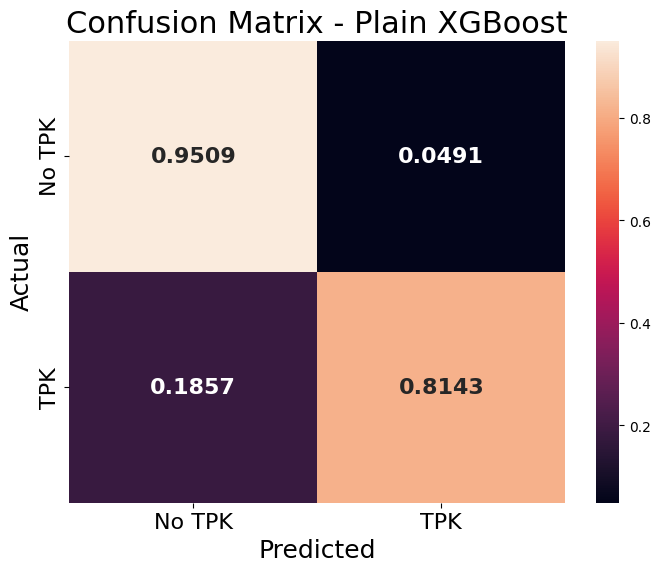

In [21]:
plot_heatmap(X_test,Y_test, clfXGB, title);

#### Classification report

In [22]:
print_classification_report(Y_test,X_test,clfXGB, title)

Classification Report - Plain XGBoost

              precision    recall  f1-score   support

       False       0.91      0.95      0.93     13877
        True       0.89      0.81      0.85      6687

    accuracy                           0.91     20564
   macro avg       0.90      0.88      0.89     20564
weighted avg       0.91      0.91      0.91     20564



#### Feature importance

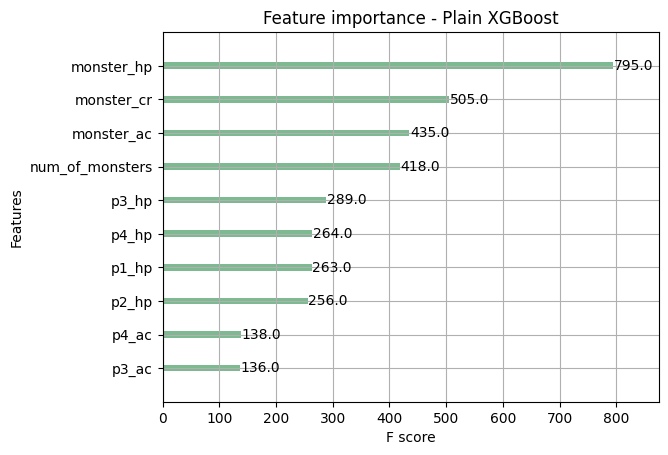

In [23]:
plot_importance(clfXGB, max_num_features=10, title=f'Feature importance - {title}');

#### Plotting the ROC curve

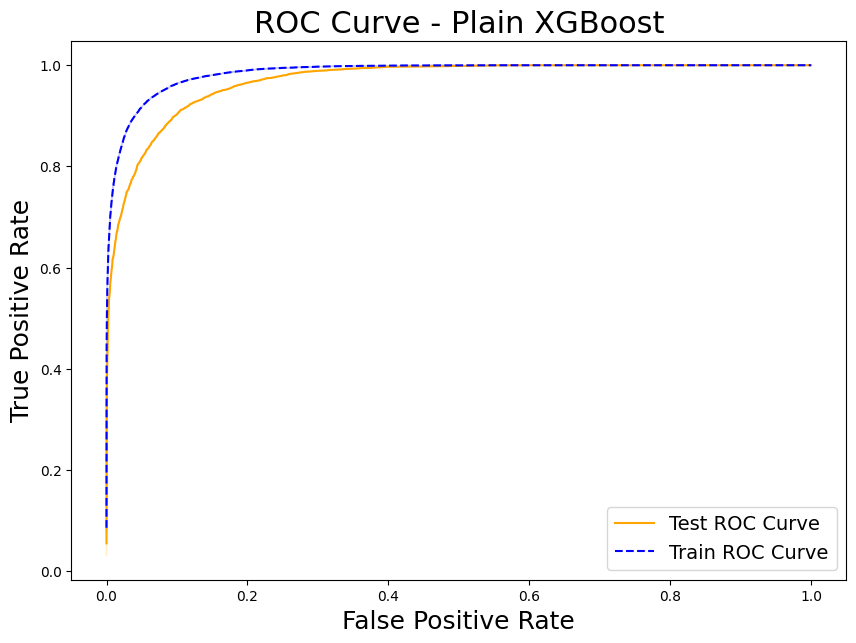

In [24]:
plot_roc_curve(X_test, Y_test, X_train, Y_train, clfXGB, title)

## Tuning the hyperparameters using ``Optuna``

### Defining the objective function

In [25]:
skf = StratifiedKFold(10, shuffle=True, random_state=7)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=7, n_jobs=-1)

    return cross_val_score(cls, X_train, Y_train,
                           cv=skf, scoring='accuracy').mean()

### Training the model while tuning the hyperparameters

In [26]:
# # Criação do estudo e procura pelos hiperparâmetros
# studyXGB = optuna.create_study(direction='maximize', study_name='classification')
# studyXGB.optimize(objective, n_trials=100, n_jobs=-1)
# studyXGB.best_params

### Model best parameters

In [81]:
# params = studyXGB.best_params
params = {
    'n_estimators': 200,
    'max_depth': 7,
    'learning_rate': 0.2,
    'gamma': 0.3,
    'min_child_weight': 5,
    'colsample_bytree': 0.6000000000000001
}

### Training the model with the best parameters

In [84]:
xgb_optuna = XGBClassifier(early_stopping_rounds=10, eval_metric='auc')
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, Y_train, verbose=20,eval_set=[(X_train, Y_train),(X_test, Y_test)]);

[0]	validation_0-auc:0.88350	validation_1-auc:0.87974
[20]	validation_0-auc:0.94489	validation_1-auc:0.93612
[40]	validation_0-auc:0.95940	validation_1-auc:0.94793
[60]	validation_0-auc:0.96957	validation_1-auc:0.95635
[80]	validation_0-auc:0.97639	validation_1-auc:0.96183
[100]	validation_0-auc:0.98100	validation_1-auc:0.96531
[120]	validation_0-auc:0.98440	validation_1-auc:0.96779
[140]	validation_0-auc:0.98688	validation_1-auc:0.97000
[160]	validation_0-auc:0.98956	validation_1-auc:0.97290
[180]	validation_0-auc:0.99118	validation_1-auc:0.97411
[199]	validation_0-auc:0.99223	validation_1-auc:0.97473


### Looking at the model results

In [29]:
title = 'XGBoost with Optuna'

#### Confusion matrix

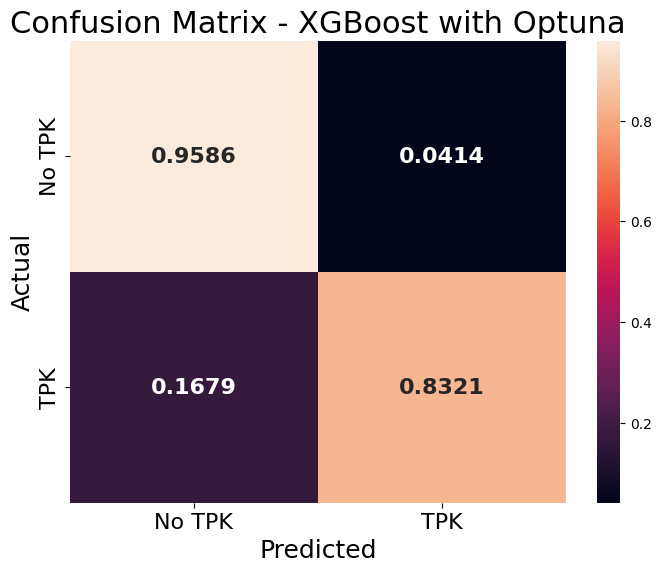

In [30]:
plot_heatmap(X_test,Y_test, xgb_optuna, title);

#### Printing the classification report

In [31]:
print_classification_report(Y_test,X_test,xgb_optuna, title)

Classification Report - XGBoost with Optuna

              precision    recall  f1-score   support

       False       0.92      0.96      0.94     13877
        True       0.91      0.83      0.87      6687

    accuracy                           0.92     20564
   macro avg       0.91      0.90      0.90     20564
weighted avg       0.92      0.92      0.92     20564



#### Plotting the feature importance

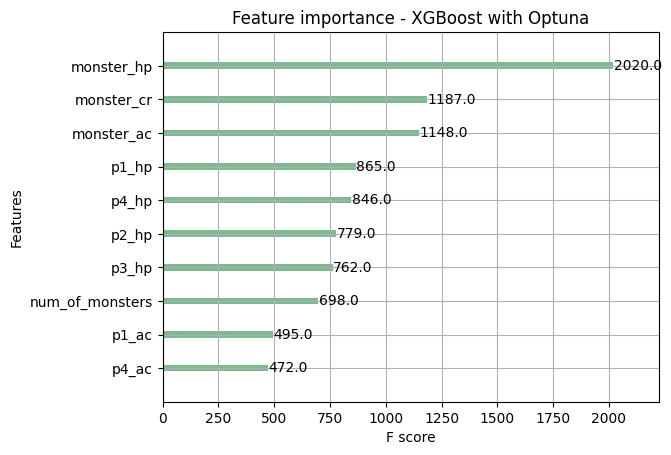

In [32]:
plot_importance(xgb_optuna, max_num_features=10, title=f'Feature importance - {title}');

#### Plotting the ROC curve

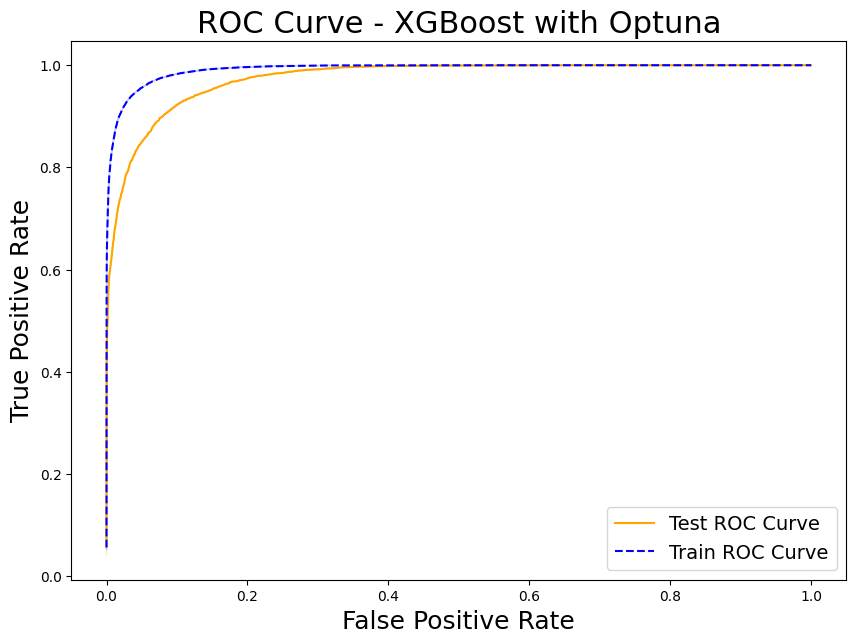

In [33]:
plot_roc_curve(X_test, Y_test, X_train, Y_train, xgb_optuna, title)

## Tuning the ``scale_pos_weight`` hyperparameter to balance the true negatives and true positives

### Tuning the ``scale_pos_weight`` 

In [34]:
# params['scale_pos_weight'] = scale_pos_weight_balancing(params, 0.5, 3, 0.01, X_train, Y_train, X_test, Y_test)

In [89]:
params['scale_pos_weight'] = 2.45

### Training the model with the best parameters

In [90]:
xgb_optuna = XGBClassifier(early_stopping_rounds=10, eval_metric='auc')
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, Y_train, verbose=20,eval_set=[(X_train, Y_train),(X_test, Y_test)]);

[0]	validation_0-auc:0.87371	validation_1-auc:0.86894
[20]	validation_0-auc:0.94764	validation_1-auc:0.93807
[40]	validation_0-auc:0.96082	validation_1-auc:0.94685
[60]	validation_0-auc:0.97133	validation_1-auc:0.95623
[80]	validation_0-auc:0.97973	validation_1-auc:0.96300
[100]	validation_0-auc:0.98432	validation_1-auc:0.96708
[120]	validation_0-auc:0.98719	validation_1-auc:0.96900
[140]	validation_0-auc:0.98933	validation_1-auc:0.97082
[160]	validation_0-auc:0.99115	validation_1-auc:0.97233
[180]	validation_0-auc:0.99256	validation_1-auc:0.97334
[199]	validation_0-auc:0.99346	validation_1-auc:0.97387


### Looking at the model results

In [95]:
title = 'XGBoost with Optuna \nand Scale Pos Weight'

#### Plotting the confusion matrix

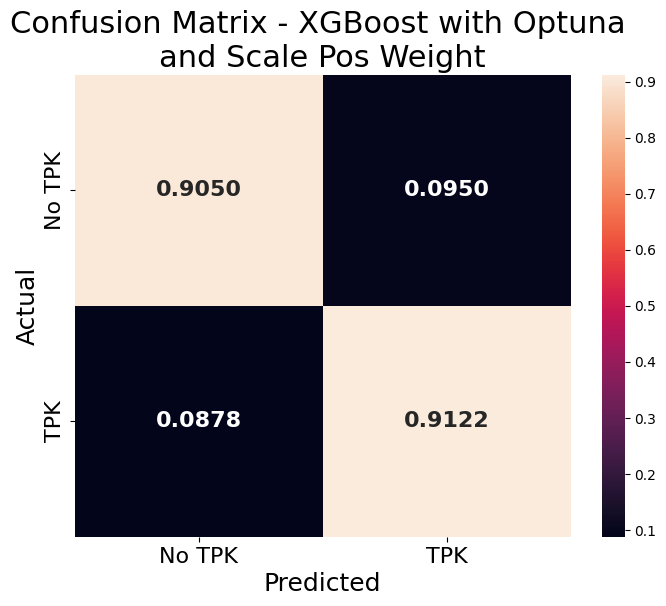

In [97]:
plot_heatmap(X_test,Y_test, xgb_optuna, title);

#### Printing the classification report

In [98]:
print_classification_report(Y_test,X_test,xgb_optuna, title)

Classification Report - XGBoost with Optuna 
and Scale Pos Weight

              precision    recall  f1-score   support

       False       0.96      0.91      0.93     13877
        True       0.82      0.91      0.86      6687

    accuracy                           0.91     20564
   macro avg       0.89      0.91      0.90     20564
weighted avg       0.91      0.91      0.91     20564



#### Plotting the feature importance

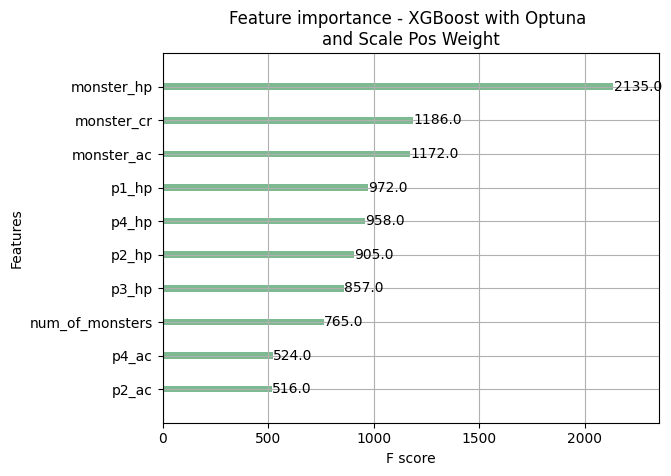

In [57]:
plot_importance(xgb_optuna, max_num_features=10, title=f'Feature importance - {title}');

#### Plotting the ROC curve

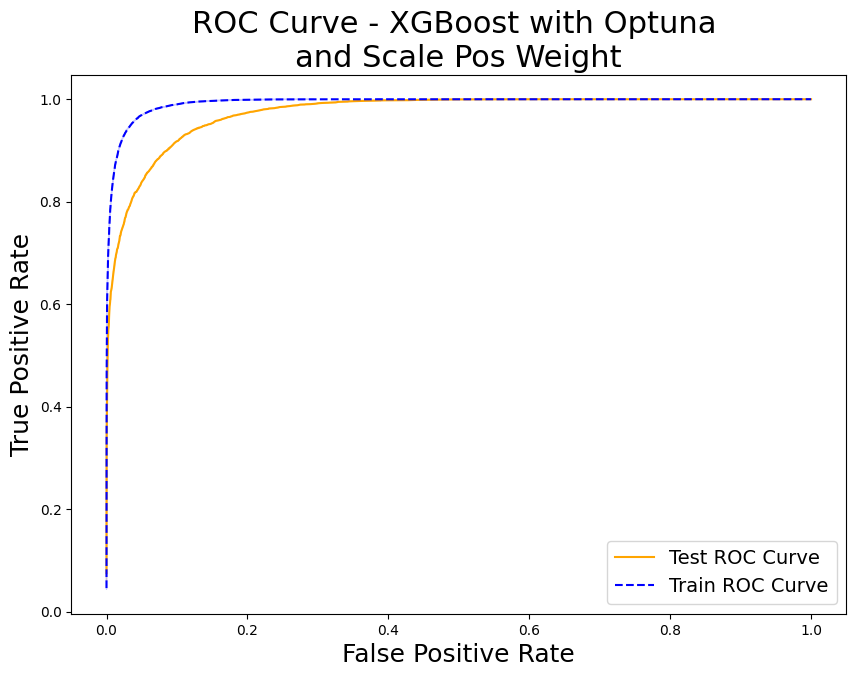

In [58]:
plot_roc_curve(X_test, Y_test, X_train, Y_train, xgb_optuna, title)

## Training a model with the best hyperparameters on normalized data

### Normalizing the data

#### Creating the normalizer object

In [42]:
from sklearn.preprocessing import MinMaxScaler

normalizer_class = MinMaxScaler()

#### Normalizing the data

In [43]:
X_encoded_normalized = normalizer_class.fit_transform(X_encoded)
X_encoded_normalized = pd.DataFrame(X_encoded_normalized, columns=X_encoded.columns)

#### Normalizing the test data

In [44]:
df_test_encoded_normalized = normalizer_class.transform(df_test_encoded)
df_test_encoded_normalized = pd.DataFrame(df_test_encoded_normalized, columns=df_test_encoded.columns)

### Splitting the data into training and validation sets

In [45]:
X_train_normalized, X_test_normalized, Y_train_normalized, Y_test_normalized = train_test_split(X_encoded_normalized, Y, test_size=0.2, random_state=7)

### Defining the objective function

In [59]:
skf = StratifiedKFold(10, shuffle=True, random_state=7)

def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=7, n_jobs=-1)

    return cross_val_score(cls, X_train_normalized, Y_train_normalized,
                           cv=skf, scoring='accuracy').mean()

### Training the model while tuning the hyperparameters

In [47]:
# # Criação do estudo e procura pelos hiperparâmetros
# studyXGB = optuna.create_study(direction='maximize', study_name='classification')
# studyXGB.optimize(objective, n_trials=100, n_jobs=-1)
# studyXGB.best_params

### Model best parameters

In [99]:
# params = studyXGB.best_params
params = {
    'n_estimators': 186,
    'max_depth': 7,
    'learning_rate': 0.2,
    'gamma': 0.2,
    'min_child_weight': 5,
    'colsample_bytree': 0.7
}

### Tuning the ``scale_pos_weight`` 

In [60]:
# params['scale_pos_weight'] = scale_pos_weight_balancing(params, 0.5, 3, 0.01, X_train_normalized, Y_train_normalized, X_test_normalized, Y_test_normalized)

In [100]:
params['scale_pos_weight'] = 2.5

### Training the model with the best parameters

In [104]:
xgb_optuna_normalized = XGBClassifier(early_stopping_rounds=10, eval_metric='auc')
xgb_optuna_normalized.set_params(**params)

xgb_optuna_normalized.fit(X_train, Y_train, verbose=20,eval_set=[(X_train, Y_train),(X_test, Y_test)]);

[0]	validation_0-auc:0.87414	validation_1-auc:0.86884
[20]	validation_0-auc:0.94815	validation_1-auc:0.93820
[40]	validation_0-auc:0.96287	validation_1-auc:0.94921
[60]	validation_0-auc:0.97250	validation_1-auc:0.95748
[80]	validation_0-auc:0.98005	validation_1-auc:0.96396
[100]	validation_0-auc:0.98402	validation_1-auc:0.96699
[120]	validation_0-auc:0.98728	validation_1-auc:0.96965
[140]	validation_0-auc:0.99005	validation_1-auc:0.97243
[160]	validation_0-auc:0.99183	validation_1-auc:0.97387
[180]	validation_0-auc:0.99344	validation_1-auc:0.97522
[185]	validation_0-auc:0.99371	validation_1-auc:0.97552


### Looking at the model results

In [72]:
title = 'XGBoost with Optuna,\n Scale Pos Weight and Normalized Data'

### Plotting the confusion matrix

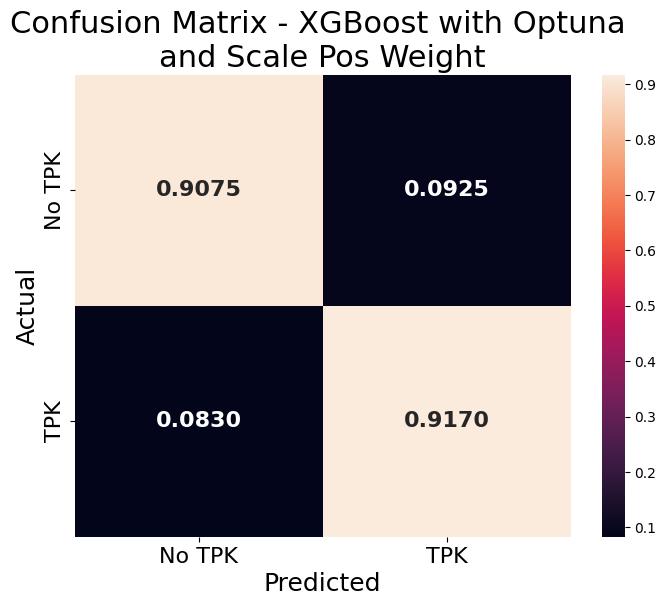

In [105]:
plot_heatmap(X_test,Y_test, xgb_optuna_normalized, title);

#### Printing the classification report

In [108]:
print_classification_report(Y_test,X_test,xgb_optuna_normalized, title)

Classification Report - XGBoost with Optuna 
and Scale Pos Weight

              precision    recall  f1-score   support

       False       0.96      0.91      0.93     13877
        True       0.83      0.92      0.87      6687

    accuracy                           0.91     20564
   macro avg       0.89      0.91      0.90     20564
weighted avg       0.92      0.91      0.91     20564



#### Plotting the feature importance

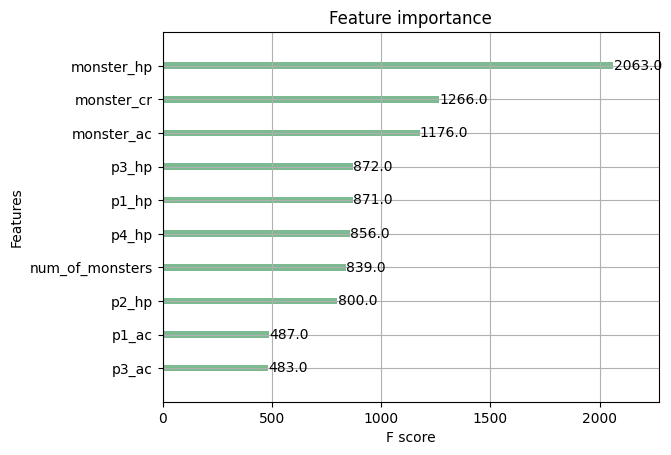

In [107]:
plot_importance(xgb_optuna_normalized, max_num_features=10);

#### Plotting the ROC curve

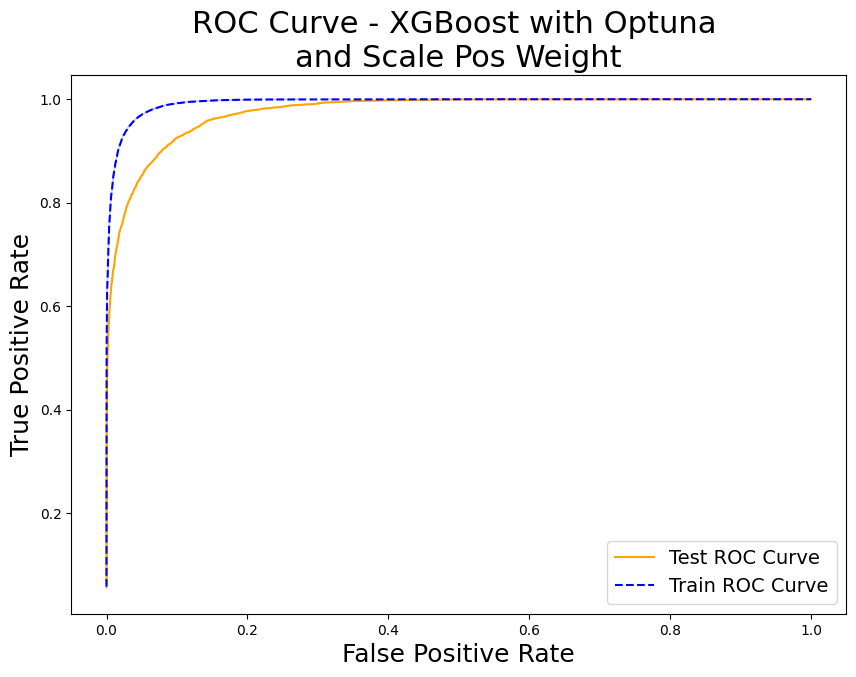

In [109]:
plot_roc_curve(X_test, Y_test, X_train, Y_train, xgb_optuna_normalized, title)

# Saving the final model

In [ ]:
xgb_optuna_normalized.save_model('model_opt_normalized_classification.ubj')

# Making predictions on the test data

In [115]:
predict(xgb_optuna_normalized, df_test_encoded_normalized, df_test_result, normalizer=normalizer_class)

Input: 


,p1_hp,p1_ac,p1_avg_save,p2_hp,p2_ac,p2_avg_save,p3_hp,p3_ac,p3_avg_save,p4_hp,...,monster_type_dragon,monster_type_elemental,monster_type_fey,monster_type_fiend,monster_type_giant,monster_type_humanoid,monster_type_monstrosity,monster_type_ooze,monster_type_plant,monster_type_undead
69,0.385714,0.4,1.0,0.405797,0.4,1.0,0.352113,0.5,1.0,0.173913,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


The combat was between 4 players level 4.0 against 1.0 monster(s) CR 6.0
Expected:  True
<class 'numpy.ndarray'>
Predicted:  False


In [117]:
from xgboost import XGBRegressor


model_loaded_class = XGBClassifier()
model_loaded_class.load_model('model_opt_normalized_classification.ubj')
model_loaded_reg = XGBRegressor()
model_loaded_reg.load_model('model_OPT_NORMALIZED.ubj')
new_data = pd.read_csv('../Data/test_sample.csv', encoding='utf-8')
new_data = new_data.iloc[randint(0,4000)].T.to_frame().T


classification_features_df = encoder_class.transform(new_data[['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type']]) # type: ignore
classification_data_encoded = pd.concat([new_data, classification_features_df], axis=1).drop(columns=['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type', 'monster_name','dificulty'])
classification_data_encoded_normalized = normalizer_class.transform(classification_data_encoded)


print(model_loaded_class.predict(classification_data_encoded_normalized))
print(model_loaded_reg.predict(classification_data_encoded_normalized))
print(new_data.dificulty.values[0])


[0]
[0.50091]
0.3136459863800475
